# Convergence

BioSTEAM iteratively solves for phase equilibria and mass and energy balances until they converge below a specified tolerance. Here we discuss ways to adjust the convergence criteria, issues that might affect convergence, and ways to customize convergence algorithms.

## Recycle systems

### Adjusting convergence criteria

In [1]:
from biosteam import System
System.default_maxiter # -> 200
System.default_molar_tolerance # -> 1. [kmol/hr] for each component 
System.default_relative_molar_tolerance # -> 0.01 
System.default_temperature_tolerance # -> 0.10 [K]
System.default_relative_temperature_tolerance # -> 0.001
System.default_methods['Sequential modular']; # -> 'Aitken'
# Changing any of these would change the default for 
# all new recycle systems you create.

For a recycle system to converge, the difference between molar flow rate of the final and previous iteration must below **either** the relative or absolute molar tolerance (not both). Because the default molar tolarances are as wide as 1% or 0.01 kmol/hr, resimulating a system may give slightly different results in some cases. In the following example, we create a simple recycle loop consisting of a flash, a mixer, and a splitter:

In [2]:
import biosteam as bst
bst.nbtutorial() # Light-mode html diagrams and filter warnings
bst.settings.set_thermo(['Water'])
feed = bst.Stream('feed', Water=1)
recycle = bst.Stream('recycle')
liquid_product = bst.Stream('liquid_product')
mixer = bst.Mixer('mixer', [feed, recycle])
flash = bst.Flash('flash', mixer-0, ['vapor_product', ''], Q=feed.Hvap, P=101325)
splitter = bst.Splitter('splitter', flash.liquid, outs=[recycle, liquid_product], split=0.1) # flash.liquid is flash.outs[1]
sys = bst.main_flowsheet.create_system('sys')
sys.simulate()
sys.diagram()
sys.show()

System: sys
Highest convergence error among components in recycle
stream splitter-0 after 2 loops:
- flow rate   5.71e-04 kmol/hr (9.1%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  1
outs...
[0] vapor_product  
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.943
[1] liquid_product  
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.0566


In [3]:
sys.empty_recycles() # Restart simulation
sys.set_tolerance(mol=1e-9, rmol=1e-9) # Set absolute and relative tolerances
sys.simulate()
sys.show()

System: sys
Highest convergence error among components in recycle
stream splitter-0 after 3 loops:
- flow rate   1.13e-17 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  1
outs...
[0] vapor_product  
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.943
[1] liquid_product  
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.0571


### Convergence methods

It may be possible that a system may be more efficient to converge using another solver. Here is a list of solvers available in BioSTEAM:

In [4]:
list(bst.System.available_methods)

['aitken',
 'wegstein',
 'fixedpoint',
 'anderson',
 'diagbroyden',
 'excitingmixing',
 'linearmixing',
 'broyden1',
 'broyden2']

In [5]:
sys.set_tolerance(method='diagbroyden')
sys.empty_recycles()
sys.simulate()
sys.show()

System: sys
Highest convergence error among components in recycle
stream splitter-0 after 4 loops:
- flow rate   1.56e-11 kmol/hr (2.5e-07%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  1
outs...
[0] vapor_product  
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.943
[1] liquid_product  
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.0571


In [6]:
from scipy.optimize import root
bst.System.register_method(
    # Set solver tolerances extreemly high so that it does not stop early and
    # only stops when BioSTEAM's tolerances are satisfied.
    name='hybr', solver=root, options=dict(xtol=1e-24, maxfev=int(1e6), method='hybr')
)
sys.set_tolerance(method='hybr')
sys.empty_recycles()
sys.simulate()
sys.show()

System: sys
Highest convergence error among components in recycle
stream splitter-0 after 7 loops:
- flow rate   4.57e-12 kmol/hr (7.2e-08%)
- temperature 0.00e+00 K (0%)
ins...
[0] feed  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  1
outs...
[0] vapor_product  
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.943
[1] liquid_product  
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  0.0571


### Importance of thermodynamic property package

The choice of thermodynamic property package may have a large impact in the results, regardless of convergence. For example, in the liquefaction of nitrogen, it is important to account for excess thermodynamic energies due to high pressures.

In [7]:
import biosteam as bst
bst.main_flowsheet.clear()

# Setup thermodynamic backend
N2 = bst.Chemical('N2')
bst.settings.set_thermo([N2])

# Heat integration between inlet and recycle
inlet = bst.Stream("inlet", N2=2.75, units="kg/s", T=6.85+273.15, P=200e5, phase="g")
flash_gas = bst.Stream("flash_gas")
regenerator = bst.units.HXprocess("regenerator", ins=(inlet, flash_gas), outs=("throttle_in", 'out'), dT=9.55)
throttle_in = regenerator.outs[0]

# Throttling
valve = bst.units.IsenthalpicValve("expansion", ins=throttle_in, outs="valve_out", P=1e5, vle=True)
valve_out = valve.outs[0]

# Flash drum
flash = bst.units.Flash("flash", ins=valve_out, outs=(flash_gas, "flash_liquid"), Q=0, P=1e5)

# Connect flash gas to regenerator
regenerator.ins[1] = flash.vapor
    
sys = bst.main_flowsheet.create_system('N2_liquefaction')
sys.set_tolerance(mol=1e-9, rmol=1e-9, T=1e-5, rT=1e-5)
bst.settings.mixture.include_excess_energies = False
sys.simulate()
sys.diagram()
print('Results without excess free energies')
print('------------------------------------')
sys.show()
print()
print('Results with excess free energies')
print('------------------------------------')
sys.reset_cache() # Resets cached chemical/mixture properties
bst.settings.mixture.include_excess_energies = True
sys.empty_recycles()
sys.simulate()
sys.show()

Results without excess free energies
------------------------------------
System: N2_liquefaction
Highest convergence error among components in recycle
stream flash-0 after 2 loops:
- flow rate   0.00e+00 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] inlet  
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  353
outs...
[0] out  
    phase: 'g', T: 280 K, P: 100000 Pa
    flow (kmol/hr): N2  353
[1] flash_liquid  
    phase: 'l', T: 280 K, P: 100000 Pa
    flow: 0

Results with excess free energies
------------------------------------
System: N2_liquefaction
Highest convergence error among components in recycle
stream flash-0 after 11 loops:
- flow rate   1.53e-12 kmol/hr (4.7e-13%)
- temperature 0.00e+00 K (0%)
ins...
[0] inlet  
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  353
outs...
[0] out  
    phase: 'g', T: 270.45 K, P: 100000 Pa
    flow (kmol/hr): N2  325
[1] flash_liquid  
    phase: 'l', T: 77.244 K, P: 100000 Pa
    flow (kmol/hr): N2  2

It may be preferable to use other methods for computing thermodynamic properties. For example, we can change the heat capacity methods to [CoolProp](http://www.coolprop.org/), which is known to be very rigorous:

In [8]:
N2.Cn.l.method = N2.Cn.g.method = "COOLPROP" # You may need to "pip install coolprop" for this
N2.reset_free_energies() # This is necessary to update enthalpy and entropy algorithms with new heat capacities
sys.reset_cache()
sys.empty_recycles()
sys.simulate()
sys.show()

System: N2_liquefaction
Highest convergence error among components in recycle
stream flash-0 after 11 loops:
- flow rate   9.66e-13 kmol/hr (0%)
- temperature 0.00e+00 K (0%)
ins...
[0] inlet  
    phase: 'g', T: 280 K, P: 2e+07 Pa
    flow (kmol/hr): N2  353
outs...
[0] out  
    phase: 'g', T: 270.45 K, P: 100000 Pa
    flow (kmol/hr): N2  325
[1] flash_liquid  
    phase: 'l', T: 77.244 K, P: 100000 Pa
    flow (kmol/hr): N2  28.2


### Process specification issues

At times, a process specification might involve having to rerun upstream unit operations. In such cases, it may be easier to set the system to run more than once than to code-in the simulation of upstream units. For demonstration purposes, let's specify a mixer's product flow rate of water to be constant by varying one of the feeds:

In [9]:
bst.main_flowsheet.clear()
bst.settings.set_thermo(['Water'])
feed_a = bst.Stream('feed_a')
heat_exchanger = bst.HXutility('heat_exchanger', feed_a, T=320, rigorous=True)
feed_b = bst.Stream('feed_b', Water=1e3)
mixer = bst.Mixer('mixer', [heat_exchanger-0, feed_b])
mixer_product_flow_specification = 1e6 # kmol/hr
@mixer.add_specification
def adjust_fresh_flow():
    # Updates the feed, but doesn't run the upstream heat exchanger.
    # A good solution would be to also run the heat exchanger, but here
    # we do not for demonstration purposes
    feed_a.imol['Water'] = mixer_product_flow_specification - feed_b.imol['Water']
    mixer.run()

sys = bst.main_flowsheet.create_system('sys')
sys.simulate()
heat_exchanger.show()

HXutility: heat_exchanger
ins...
[0] feed_a  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  9.99e+05
outs...
[0] s1  to  Mixer-mixer
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [10]:
sys.N_runs = 2 # Run twice in simulate method
sys.empty_recycles()
sys.simulate()
heat_exchanger.show()

HXutility: heat_exchanger
ins...
[0] feed_a  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  9.99e+05
outs...
[0] s1  to  Mixer-mixer
    phases: ('g', 'l'), T: 320 K, P: 101325 Pa
    flow (kmol/hr): (l) Water  9.99e+05


## Phase equilibrium and energy balance

### Adjusting convergence criteria

In [11]:
from thermosteam import Mixture
Mixture.T_tol # -> 1e-6
Mixture.maxiter; # -> 20

Thermodynamic phase equilibrium algorithms also have a number of tolerances that may be adjusted:

In [12]:
from thermosteam.equilibrium import VLE
VLE.maxiter # -> 20 [-]
VLE.T_tol # -> 5e-8 [K]
VLE.P_tol # -> 1. [Pa]
VLE.H_hat_tol # -> 1e-6 [J/g]
VLE.S_hat_tol # -> 1e-6 [J/g/K]
VLE.V_tol # -> 1e-6 [mol %] 
VLE.x_tol # -> 1e-9 [mol %]
VLE.y_tol; # -> 1e-9 [mol %]

The tolerances thermodynamic convergence are purposefully low for stable system convergence. In rare occasions, these algorithms may fail to converge and increasing the maximum number of iterations, `maxiter`, may help. Increasing tolerances may also help convergence of a unit operation, but may cause instabilities to recycle systems.

### Importance of thermodynamic property package

As an example to drive home how important it is to understand the impact of thermodynamic and phase equilibrium assumptions, let's compare the phase envelope of ethanol and water with and without activity coefficients:

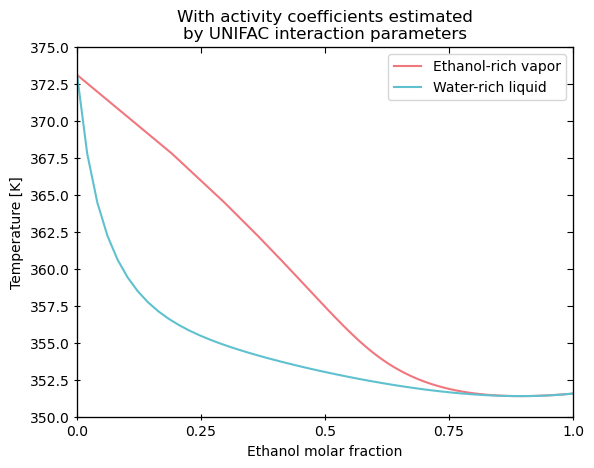

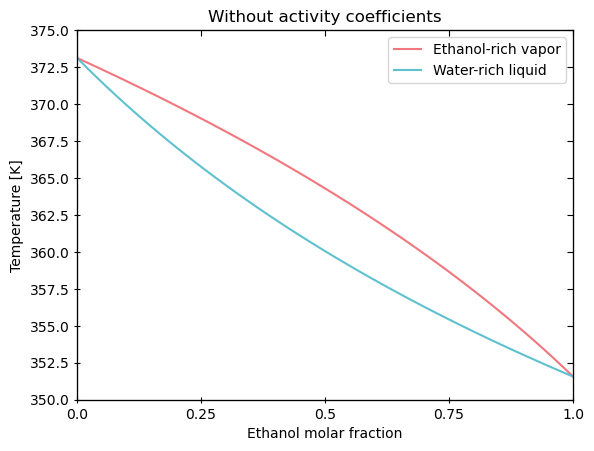

In [13]:
import thermosteam as tmo
import matplotlib.pyplot as plt
tmo.settings.set_thermo(['Ethanol', 'Water'])
eq = tmo.equilibrium # Thermosteam's equilibrium module
eq.plot_vle_binary_phase_envelope(['Ethanol', 'Water'], P=101325)
plt.title('With activity coefficients estimated\nby UNIFAC interaction parameters')
plt.show()
tmo.settings.set_thermo(['Ethanol', 'Water'], ideal=True)
eq.plot_vle_binary_phase_envelope(['Ethanol', 'Water'], P=101325)
plt.title('Without activity coefficients')
plt.show()

Note how no azeotrope is predicted for the ideal thermodynamic model. When working with non-polar hydrocarbons, however, it becomes feasible to ignore interaction parameters:

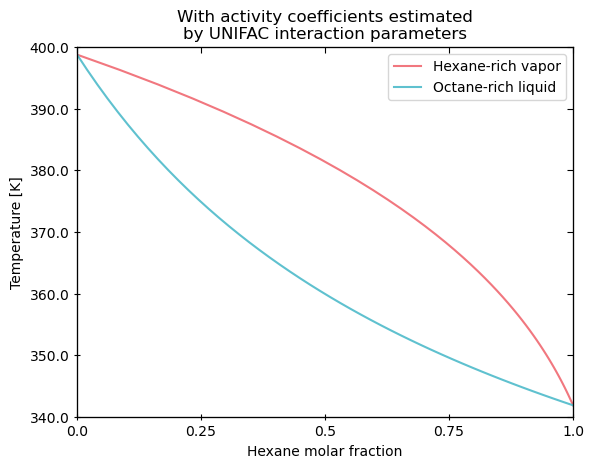

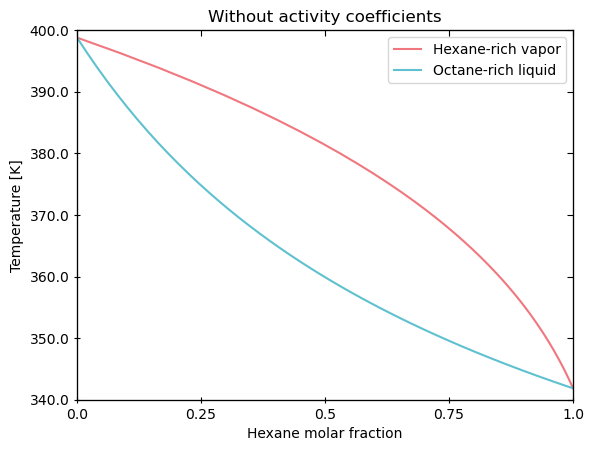

In [14]:
import thermosteam as tmo
import matplotlib.pyplot as plt
tmo.settings.set_thermo(['Hexane', 'Octane'])
eq = tmo.equilibrium # Thermosteam's equilibrium module
eq.plot_vle_binary_phase_envelope(['Hexane', 'Octane'], P=101325)
plt.title('With activity coefficients estimated\nby UNIFAC interaction parameters')
plt.show()
tmo.settings.set_thermo(['Hexane', 'Octane'], ideal=True)
eq.plot_vle_binary_phase_envelope(['Hexane', 'Octane'], P=101325)
plt.title('Without activity coefficients')
plt.show()